## Building Detection via Mask-R CNN and Spacenet V2 Data

This notebook is based on the train_shapes ipynb instructional file available on Matterport's Mask R-CNN [Github Repository](https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb).  The model in use has been made compatible for use with Tensorflow 2.0+ versions by Adam Kelly ([github repository](https://github.com/akTwelve/Mask_RCNN))

The Training Data for Kartoum (downloaded from [Radiant MLHub](https://mlhub.earth/data/spacenet2)) contains 1012 aerial images and associated masks covering individual buildings.
Images and masks have been preprocessed in 04_Training_Data

In [1]:
# Drive Working Directory
from google.colab import drive
drive.mount('/content/drive/')

import os
# !ls drive/MyDrive/house_finder/
os.path.abspath('./drive/MyDrive/house_finder/Mask_RCNN/')

Mounted at /content/drive/


'/content/drive/MyDrive/house_finder/Mask_RCNN'

In [2]:
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import skimage.io
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

%matplotlib inline

In [3]:
# Root directory of the project
ROOT_DIR = os.path.abspath("./drive/MyDrive/house_finder/Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs/")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Configurations for Spacenet Data

In [4]:
class SpaceNetConfig(Config):
  """
  Configuration for training on Spacenet V2 Data.
  Derives from the base Config Class and overrides values specific to the use case.
  """
  NAME = "SpaceNet"
  BACKBONE = "resnet50"
  # Train on 1 GPU and 8 images per GPU.  Images here are reasonably small
  GPU_COUNT = 1
  IMAGES_PER_GPU = 8

  # Number of Classes (including background)
  NUM_CLASSES = 1 + 1
  """
  NOTE: In an ideal workflow, multiple classes of buildings would be available for
  detailed building categorization by roof profile.  Here the number of classes would be:
  1 (background)
    + (n_roof colors (ex. red, black, gray, silver, yellow)
      *
      (m_roof profiles (ex. flat, single peak, T, hip-val, etc.))
  """

  # Use Small images for fater training, set limits on image size
  IMAGE_MIN_DIM = 640
  IMAGE_MAX_DIM = 640

  # Use smaller anchors because our image and objects are small
  RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
  RPN_ANCHOR_RATIOS = (0.25, 1, 4)

  # Reduce training ROIs per image because the images are small and have
  # few objects.  Aim to allow ROI sampling to pick 33% positive ROIs
  TRAIN_ROIS_PER_IMAGE = 35
  LEARNING_RATE = 0.01

  USE_MINI_MASK = False
  # Bob Adams Description from code and documentation:
  # Mini Masks reduce the memory usage during training and prediction by only\
  # saving information inside a smaller consistent mask shape for each object.
  # Example: if a 1000px x 1000px image has 10 objects, 10 1000x1000px mask\
  # objects will be saved in memory.  This is removed in this implementation due\
  #


  # Use a moderately sized epoch as our data is moderately complex.
  STEPS_PER_EPOCH = 100

  #Scale validation steps for the epoch size
  VALIDATION_STEPS = 50

  MAX_GT_INSTANCES = 250
  DETECTION_MAX_INSTANCES = 350

config = SpaceNetConfig()
# config.display()

Notebook Preferences

In [5]:
def get_ax(rows = 1, cols = 1, size = 8):
  _, ax = plt.subplots(rows, cols, figsize = (size * cols, size * rows))
  return ax

def fill_between(polygon):
  ## returns a boolean array filling in the set polygon
  img = Image.new('1', (650, 650), False)
  ImageDraw.Draw(img).polygon(polygon, outline = True, fill = True)
  mask = np.array(img)
  return mask

Dataset

In [6]:
!pip install rioxarray
import rioxarray
!pip install rasterio
import rasterio
import rasterio.mask
import json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 78.6 MB/s eta 0:00:00


In [7]:
# training data hosted in drive
data_dir = './drive/MyDrive/house_finder/spacenetv2_khartoum/'
#if run locally
# training_dir = '.../data/training_data/spacenetv2/'

class SpaceNetDataset(utils.Dataset):

  def load_dataset(self, dataset_dir, start = 1, end = 1000):
    self.add_class("SpaceNetDataset", 1, "building")

    #locate the files for training.
    # Here files have been converted from .tif and .geojson to .png
    images_dir = os.path.join(data_dir, 'images/')
    annotations_dir = os.path.join(data_dir, 'labels/')

    #Iterate through the files in the folder to add class, images, annotations
    for filename in os.listdir(images_dir)[start:end]:
      image_id = filename[3:-11] #ex. img1017PS-RGB_.png
                                     #012    yx987654321
      image_dir = os.path.join(images_dir, str(filename))
      ann_path = os.path.join(annotations_dir, "img"+str(image_id)+"label_.geojson")
      self.add_image('SpaceNetDataset' , image_id = image_id, path=image_dir, annotation = ann_path)

  def load_image(self, image_id):
    image_dir = os.path.join(data_dir, 'images/', 'img'+str(image_id)+'PS-RGB_.png')
    im = Image.open(image_dir)
    return np.asarray(im)

  def image_reference(self, image_id):
    info = self.image_info[image_id]
    if info['source'] == 'shapes':
      return info['shapes']
    else:
      super(self.__class__).image_reference(self, image_id)

# Returns single, uniform mask - not suitable for image segmentation
  # def load_mask(self, image_id):
  #   mask_path = os.path.join(data_dir, 'maps', str(image_id)+'mask_.png')
  #   mask_img = cv2.imread(mask_path, 0)

  #   if mask_img.shape != (650,650):
  #     masks = mask_img[:,:,1:]
  #     class_ids = np.asarray([1] * masks.shape[2])
  #   else:
  #     class_ids = np.ones((1))
  #     masks = mask_img.reshape((650,650,1))

  #   mask_arr = np.array(masks)
  #   return mask_arr.astype(np.bool), class_ids.astype(np.int32)


# Cite: https://github.com/Mstfakts/Building-Detection-MaskRCNN/blob/master/SpaceNet_train.py
# This approach requires the use of geoio - a library out of date with current versions of Python

  # def load_mask(self, image_id):
  #   """Generate instance masks for shapes of the given image ID.
  #   """
  #   masks = np.zeros((650,650))
  #   ResimPATH = os.path.join(data_dir, 'images/', 'img'+str(image_id)+'PS-RGB_.tif')
  #   RGBTIFResmi = geoio.GeoImage(ResimPATH)

  #   annotations_dir = os.path.join(data_dir, 'labels/')
  #   geojson_path = os.path.join(annotations_dir, "img"+str(image_id)+"label_.geojson")

  #   with open(geojson_path) as f:
  #       data = json.load(f)
  #       allBuildings = data['features']

  #       for building in allBuildings:
  #           veri = building['geometry']['coordinates'][0]

  #           tip = str(building['geometry']['type'])
  #           coordinates = list()
  #           if tip == ('Point'):
  #               continue

  #           elif tip == ('MultiPolygon'):

  #               if isinstance(veri,float): continue

  #               kucukBinalar = (building['geometry']['coordinates'])
  #               for b in range(len(kucukBinalar)):
  #                   veri = kucukBinalar[b][0]
  #                   for i in veri:
  #                       xPixel, yPixel = RGBTIFResmi.proj_to_raster(i[0], i[1])
  #                       xPixel = 649 if xPixel > 649 else xPixel
  #                       yPixel = 649 if yPixel > 649 else yPixel
  #                       coordinates.append((xPixel,yPixel))
  #           else:
  #               if isinstance(veri,float): continue

  #               for i in veri:
  #                   xPixel, yPixel = RGBTIFResmi.proj_to_raster(i[0], i[1])
  #                   xPixel = 649 if xPixel > 649 else xPixel
  #                   yPixel = 649 if yPixel > 649 else yPixel
  #                   coordinates.append((xPixel,yPixel))

  #           maske = fill_between(coordinates)
  #           masks = np.dstack((masks,maske))

  #   if masks.shape != (650,650):
  #       masks = masks[:,:,1:]
  #       class_ids = np.asarray([1]*masks.shape[2])
  #   else:
  #       class_ids=np.ones((1))
  #       masks = masks.reshape((650,650,1))
  #   return masks.astype(np.bool), class_ids.astype(np.int32)


# Leverage rioxarray functionality to convert individual geometries into arrays to be stacked for use in modeling
# cite: https://gis.stackexchange.com/a/346899
# Output Layers borrow from Mustafa Aktas' solution (also listed above)
# Cite: https://github.com/Mstfakts/Building-Detection-MaskRCNN/blob/master/SpaceNet_train.py
# Modified to stack multiple masks via dstack.

  def load_mask(self, image_id):
    # load in the geojson file
    annotations_dir = os.path.join(data_dir, 'labels/')
    geojson_path = os.path.join(annotations_dir, "img"+str(image_id)+"label_.geojson")
    with open(geojson_path) as igj:
        data = json.load(igj)
    # if GDAL 3+
    crs = data["crs"]["properties"]["name"]
    # crs = "EPSG:4326" # if GDAL 2
    buildings = [feat for feat in data["features"]]
    masks = np.zeros((650,650))

    #read in rastered image file with matching id
    img_path = os.path.join(data_dir, 'images/', 'img'+str(image_id)+'PS-RGB_.tif')
    rds = rioxarray.open_rasterio(img_path).isel(band=0)
    rds.values[:] = 1
    rds.rio.write_nodata(0,inplace=True)

    # Create an array to append class_ids
    class_ids = np.array([])

    #loop through buildings to extract mask information using geometry
    for building in buildings:
        class_id = building["properties"]["OBJECTID_1"]
        geom = [building["geometry"]]

        # clip the image via rastrio
        try:
            mask = rds.rio.clip(geom, crs, drop = False)
            # print('clip')
        except:
            mask = rds
            # print('noclip')
        # print(class_id)
        np.append(class_ids, class_id)
        mask_ar = mask.values
        masks = np.dstack((masks, mask_ar))

    if masks.shape != (650,650):
        masks = masks[:,:,1:]
        class_ids = np.asarray([1]*masks.shape[2])
    else:
        class_ids=np.ones((1))
        masks = masks.reshape((650,650,1))
    return masks.astype(np.int32), class_ids.astype(np.int32)

Train-Validate Split

In [8]:
#segment training data
dataset_train = SpaceNetDataset()
dataset_train.load_dataset(data_dir, 1, 600)
# print(dataset_train.image_info)
dataset_train.prepare()
# print(dataset_train.image_ids)

#segment validation data
dataset_val = SpaceNetDataset()
dataset_val.load_dataset(data_dir, 601, 800)
dataset_val.prepare()

In [10]:
print(dataset_train._image_ids)
print(dataset_val._image_ids)

[772, 745, 538, 981, 17, 949, 20, 699, 386, 292, 592, 42, 75, 808, 486, 199, 224, 546, 9, 213, 571, 330, 96, 452, 618, 465, 759, 246, 524, 307, 430, 271, 513, 889, 365, 352, 407, 876, 685, 118, 791, 962, 841, 955, 185, 814, 69, 823, 937, 900, 1002, 78, 926, 832, 911, 805, 973, 194, 944, 850, 780, 694, 374, 867, 416, 109, 343, 748, 421, 502, 898, 260, 474, 257, 316, 535, 202, 443, 609, 321, 87, 557, 560, 235, 819, 497, 188, 397, 53, 583, 64, 283, 688, 958, 754, 990, 529, 31, 640, 368, 122, 763, 677, 115, 884, 701, 736, 229, 4, 622, 468, 140, 177, 615, 252, 989, 530, 659, 265, 507, 424, 413, 346, 371, 552, 207, 230, 446, 324, 565, 82, 718, 159, 471, 837, 313, 923, 914, 191, 800, 691, 1007, 855, 862, 976, 785, 672, 110, 881, 28, 941, 127, 438, 645, 995, 279, 766, 610, 751, 172, 338, 627, 1, 145, 704, 56, 733, 579, 61, 908, 492, 34, 586, 849, 286, 799, 392, 383, 12, 858, 297, 788, 597, 483, 70, 25, 919, 722, 47, 568, 715, 154, 329, 163, 636, 601, 740, 777, 984, 663, 268, 136, 654, 429, 39,

In [11]:
#Validate Class IDs match definition above
dataset_train.source_class_ids[dataset_train.image_info[0]["source"]]

[0, 1]

Load and Display Random Samples

[115  25 898]
115


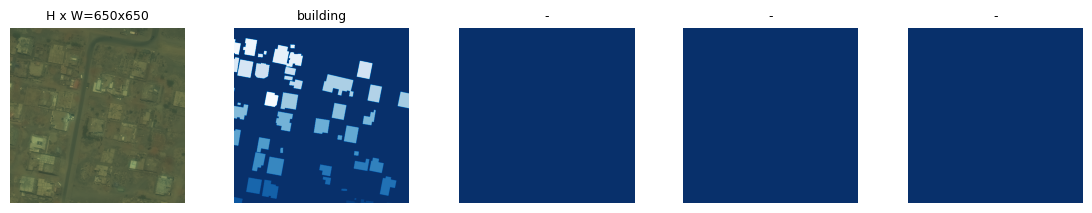

25


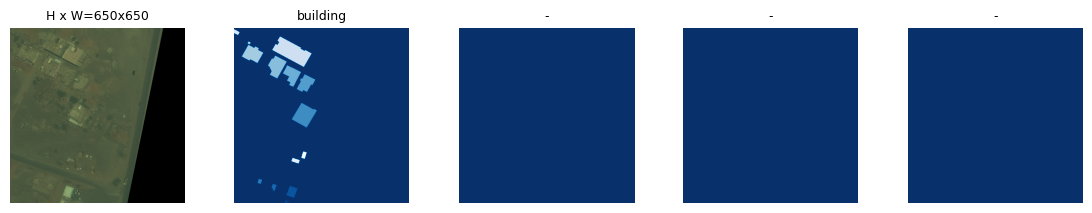

898


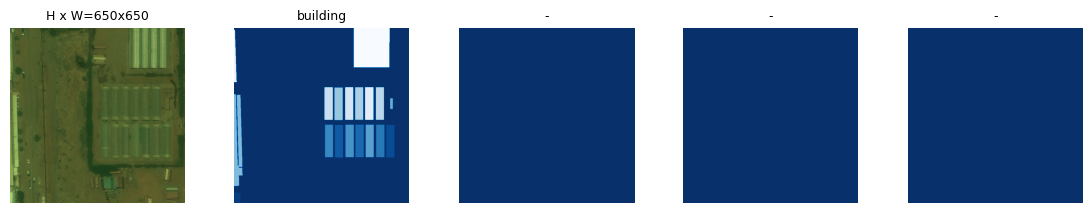

In [13]:
image_ids = np.random.choice(dataset_train.image_ids,3)
print(image_ids)

for image_id in image_ids:
    print(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

Create the Model in Training Mode

In [14]:
model = modellib.MaskRCNN(mode = "training", config = config, model_dir = MODEL_DIR)

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 17


Training Model on SpacenetV2 Data

In [ ]:
model.train(dataset_train, dataset_val,
            learning_rate = config.LEARNING_RATE,
            epochs = 20,
          layers = 'heads')

## Post-Training Inferences

In [ ]:
model_path = os.path.join(MODEL_DIR, 'mask_rcnn_spacenet.h5')
model.keras_model.save_weights(model_path)

### Configure Inferences - SpaceNetV2 Data

In [9]:
class InferenceConfig(SpaceNetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False #https://github.com/matterport/Mask_RCNN/issues/1967#issuecomment-796687115

inference_config = InferenceConfig()

#instantiate the model in inference mode
model = modellib.MaskRCNN(mode = 'inference',
                            config = inference_config,
                            model_dir = MODEL_DIR)

model_path = os.path.join(MODEL_DIR, 'mask_rcnn_spacenet.h5')

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead


Loading weights from  /content/drive/MyDrive/house_finder/Mask_RCNN/logs/mask_rcnn_spacenet.h5


original_image           shape: (640, 640, 3)         min:    1.00000  max:    1.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  927.00000  float64
gt_class_id              shape: (66,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (66, 4)               min:    0.00000  max:  640.00000  int32
gt_mask                  shape: (640, 640, 66)        min:    0.00000  max:    1.00000  int32


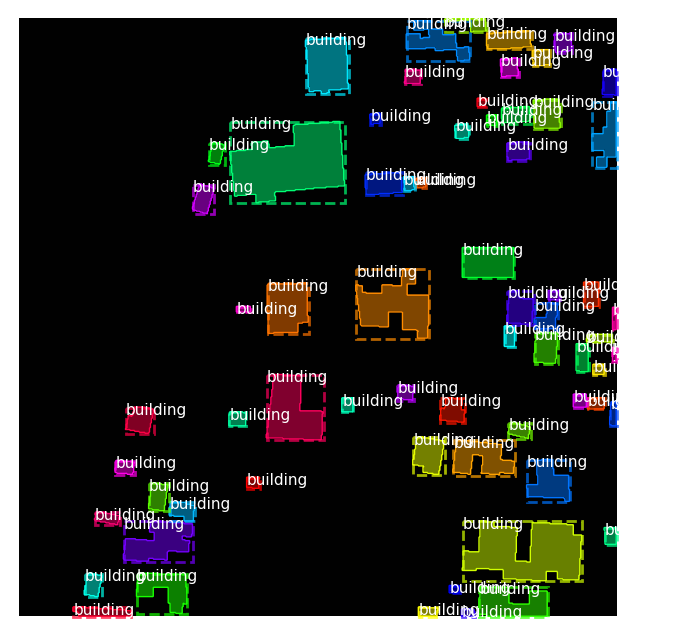

Processing 1 images
image                    shape: (640, 640, 3)         min:    1.00000  max:    1.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -122.70000  max: -102.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.20031  max:    1.10016  float32


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


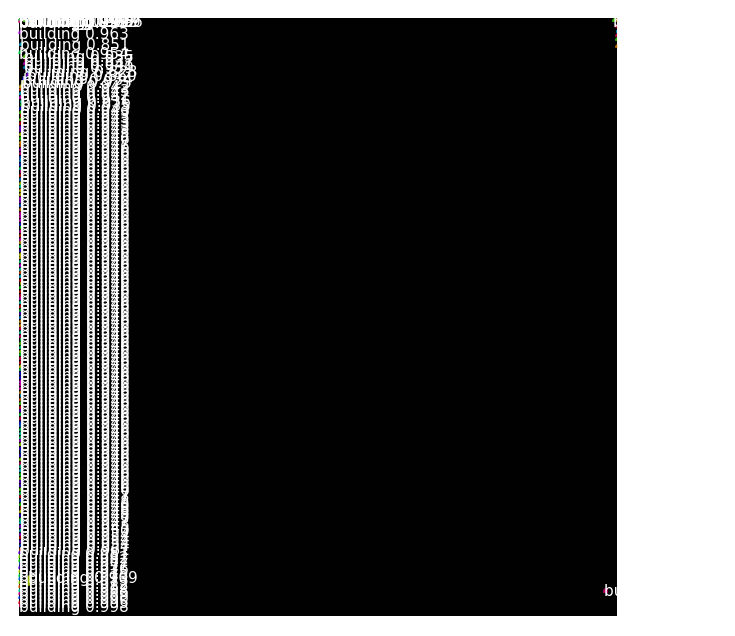

In [10]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())

Processing 1 images
image                    shape: (640, 640, 3)         min:    1.00000  max:    1.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -122.70000  max: -102.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.20031  max:    1.10016  float32


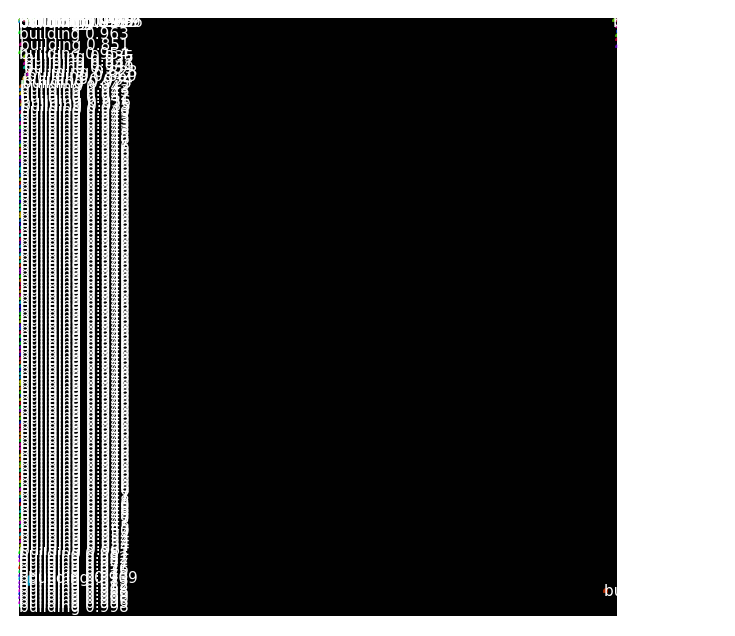

In [11]:
#display and capture model predicted results from sample image above
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())

### Model Performance Evaluation

In [68]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

print("mAP: ", np.mean(APs))

mAP:  0.0


Model training was interrupted by a version control issue in Tensorflow.

### Model Results Examination

Assess model prediction results for extenstion into new use cases.
The goal is to leverage the model output to calculate the following data points:
1. The location building object instances - this information can be used in combination with geolocation and image size information generated during satelite image capture to associate identified buildings with a latitude/longitude geolocation.
2. The mask areas generated for each building oubject instance - By understanding the pxels of the original image which are assessed by the model to comprise a building object, the average or dominant color of the mask area can be used to identify the color family of the roof of the building.

In [12]:
# Extract Center of Image from each ROI
# rois: [N, (y1, x1, y2, x2)] detection bounding boxes

def extract_building_centers(res):
  building_centers = []
  id=0
  for r in range(res['rois'].shape[0]):
    x1 = res['rois'][r][1]
    x2 = res['rois'][r][3]
    xc = np.mean([x1, x2])
    y1 = res['rois'][r][0]
    y2 = res['rois'][r][2]
    yc = np.mean([y1, y2])
    building_centers.append([id, xc, yc])
    id +=1

  return (building_centers)

In [18]:
res = results[0]
print(res['rois'].shape[0], " Detected Objects")
print("Objects are identified sequentially as returned by model predictions with the pixel-based center saved in x,y coordinates")
centers = extract_building_centers(res)
print(centers)

0  Detected Objects
Objects are identified sequentially as returned by model predictions with the pixel-based center saved in x,y coordinates
[]


In [13]:
# Extract Average Color of the original image within the bounds of the mask
#based on the logic leveraged in visualize.display_instances

def extract_roof_color(image_id, image, boxes, masks, class_ids, class_names):
  #Number of instances
  N = boxes.shape[0]
  if not N:
    print('No Objects Detected')
  else:
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

  building_colors = []

  for i in range(N):
    image_id = image_id
    im = image.astype(np.uint32).copy()
    class_id = class_ids[i]
    class_name = class_names[i]
    mask = masks[i]

    # Set all where pixels (in all color ranges) to zero in the image where the mask does not overlap
    # cite: https://stackoverflow.com/q/60001378
    for j in range(im.shape[2]):
      im[:, :, j] = im[:, :, j] * mask[:, :, i]

    red = im[:,:,0]
    red_avg = red[red > 0].mean()
    green = im[:,:,1]
    green_avg = green[green > 0].mean()
    blue = im[:,:,2]
    blue_avg = blue[blue > 0].mean()

    rgb = (red_avg, green_avg, green_avg)

    building_colors.append([image_id, class_id, class_name, rgb])

  return building_colors

In [20]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id)
results = model.detect([original_image], verbose=1)
r = results[0]
extract_roof_color(image_id, original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names)

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:    1.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.20031  max:    1.10016  float32
No Objects Detected


[]

### Configure Inferences - Captured Satelite Imagery

In [16]:
class GoogleSateliteConfig(Config):
  """
  Configuration for training on Spacenet V2 Data.
  Derives from the base Config Class and overrides values specific to the use case.
  """
  NAME = "GoogleSatelite"
  BACKBONE = "resnet50"
  # Train on 1 GPU and 8 images per GPU.  Images here are reasonably small
  GPU_COUNT = 1
  IMAGES_PER_GPU = 8

  # Number of Classes (including background)
  NUM_CLASSES = 1 + 1
  """
  NOTE: In an ideal workflow, multiple classes of buildings would be available for
  detailed building categorization by roof profile.  Here the number of classes would be:
  1 (background)
    + (n_roof colors (ex. red, black, gray, silver, yellow)
      *
      (m_roof profiles (ex. flat, single peak, T, hip-val, etc.))
  """

  # Use Small images for fater training, set limits on image size
  IMAGE_MIN_DIM = 320
  IMAGE_MAX_DIM = 320

  # Use smaller anchors because our image and objects are small
  RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
  RPN_ANCHOR_RATIOS = (0.25, 1, 4)

  # Reduce training ROIs per image because the images are small and have
  # few objects.  Aim to allow ROI sampling to pick 33% positive ROIs
  TRAIN_ROIS_PER_IMAGE = 35
  LEARNING_RATE = 0.01

  USE_MINI_MASK = False
  # Bob Adams Description from code and documentation:
  # Mini Masks reduce the memory usage during training and prediction by only\
  # saving information inside a smaller consistent mask shape for each object.
  # Example: if a 1000px x 1000px image has 10 objects, 10 1000x1000px mask\
  # objects will be saved in memory.  This is removed in this implementation due\

  # Use a moderately sized epoch as our data is moderately complex.
  STEPS_PER_EPOCH = 100

  #Scale validation steps for the epoch size
  VALIDATION_STEPS = 50

  MAX_GT_INSTANCES = 250
  DETECTION_MAX_INSTANCES = 350

config = GoogleSateliteConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        350
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [17]:
class InferenceConfig(GoogleSateliteConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False #https://github.com/matterport/Mask_RCNN/issues/1967#issuecomment-796687115

inference_config = InferenceConfig()

#instantiate the model in inference mode
model = modellib.MaskRCNN(mode = 'inference',
                            config = inference_config,
                            model_dir = MODEL_DIR)

model_path = os.path.join(MODEL_DIR, 'mask_rcnn_spacenet.h5')

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/house_finder/Mask_RCNN/logs/mask_rcnn_spacenet.h5


Inference visualization parameters

In [19]:
def get_ax(rows = 1, cols = 1, size = 8):
  _, ax = plt.subplots(rows, cols, figsize = (size * cols, size * rows))
  return ax

def fill_between(polygon):
  ## returns a boolean array filling in the set polygon
  img = Image.new('1', (320, 320), False)
  ImageDraw.Draw(img).polygon(polygon, outline = True, fill = True)
  mask = np.array(img)
  return mask

In [20]:
# data_dir = './drive/MyDrive/house_finder/spacenetv2_khartoum/'
eval_dir = './drive/MyDrive/house_finder/evaluation_images/'

class GoogleSateliteDataset(utils.Dataset):

  def load_dataset(self, dataset_dir, start = 1, end = 1000):
    self.add_class("GoogleSateliteDataset", 1, "building")

    eval_images_dir = eval_dir
    # annotations_dir = os.path.join(data_dir, 'labels/')

    #Iterate through the files in the folder to add class, images, annotations
    for filename in os.listdir(eval_images_dir)[start:end]:
      image_id = filename.split('.')[0]
      image_dir = os.path.join(eval_images_dir, str(filename)+".png")
      # ann_path = os.path.join(annotations_dir, "img"+str(image_id)+"label_.geojson")
      self.add_image('GoogleSateliteDataset' , image_id = image_id, path=image_dir)

  def load_image(self, image_id):
    image_dir = os.path.join(eval_images_dir, str(filename)+".png")
    im = Image.open(image_dir)
    return np.asarray(im)

  # def image_reference(self, image_id):
  #   info = self.image_info[image_id]
  #   if info['source'] == 'shapes':
  #     return info['shapes']
  #   else:
  #     super(self.__class__).image_reference(self, image_id)

  # def load_mask(self, image_id):
  #   # load in the geojson file
  #   annotations_dir = os.path.join(data_dir, 'labels/')
  #   geojson_path = os.path.join(annotations_dir, "img"+str(image_id)+"label_.geojson")
  #   with open(geojson_path) as igj:
  #       data = json.load(igj)
  #   # if GDAL 3+
  #   crs = data["crs"]["properties"]["name"]
  #   # crs = "EPSG:4326" # if GDAL 2
  #   buildings = [feat for feat in data["features"]]
  #   masks = np.zeros((650,650))

  #   #read in rastered image file with matching id
  #   img_path = os.path.join(data_dir, 'images/', 'img'+str(image_id)+'PS-RGB_.tif')
  #   rds = rioxarray.open_rasterio(img_path).isel(band=0)
  #   rds.values[:] = 1
  #   rds.rio.write_nodata(0,inplace=True)

  #   # Create an array to append class_ids
  #   class_ids = np.array([])

  #   #loop through buildings to extract mask information using geometry
  #   for building in buildings:
  #       class_id = building["properties"]["OBJECTID_1"]
  #       geom = [building["geometry"]]

  #       # clip the image via rastrio
  #       try:
  #           mask = rds.rio.clip(geom, crs, drop = False)
  #           # print('clip')
  #       except:
  #           mask = rds
  #           # print('noclip')
  #       # print(class_id)
  #       np.append(class_ids, class_id)
  #       mask_ar = mask.values
  #       masks = np.dstack((masks, mask_ar))

  #   if masks.shape != (650,650):
  #       masks = masks[:,:,1:]
  #       class_ids = np.asarray([1]*masks.shape[2])
  #   else:
  #       class_ids=np.ones((1))
  #       masks = masks.reshape((650,650,1))
  #   return masks.astype(np.int32), class_ids.astype(np.int32)

Select Random Images from the captured satelite photos

In [23]:
#segment evaluation data
dataset_evaluation = GoogleSateliteDataset()
dataset_evaluation.load_dataset(eval_dir, 1, 10)
dataset_evaluation.prepare()

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:    1.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max: -102.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.20031  max:    1.10016  float32

*** No instances to display *** 



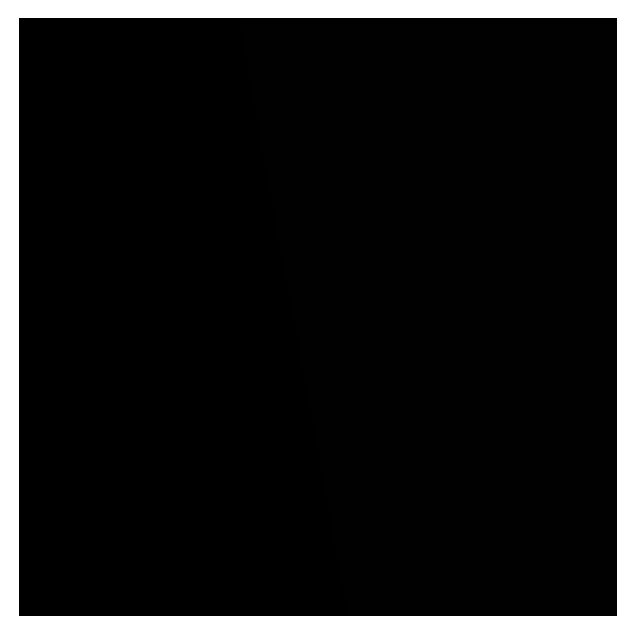

In [24]:
# Test Evaluation on a captured satelite image
image_id = random.choice(dataset_evaluation.image_ids)
image_center_lat = image_id.split('_')[0]
image_center_long = image_id.split('_')[1]

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())

# Generate Building Centers
r = results[0]
print(res['rois'].shape[0], " Detected Objects")
print("Objects are identified sequentially as returned by model predictions with the pixel-based center saved in x,y coordinates")
centers = extract_building_centers(res)


In [25]:
# Generate Building Centers
r = results[0]
print(res['rois'].shape[0], " Detected Objects")
print("Objects are identified sequentially as returned by model predictions with the pixel-based center saved in x,y coordinates")
centers = extract_building_centers(res)
centers_latlong = [[id, (((xc/300)-0.5)*0.0017) + image_center_long, (((yc/300)-0.5)*0.00128) + image_center_lat ] for [id, xc, yc] in centers]
print(centers_latlong)

building_colors = extract_roof_color(image_id, original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names)

print(building_colors)

0  Detected Objects
Objects are identified sequentially as returned by model predictions with the pixel-based center saved in x,y coordinates
[]
No Objects Detected
[]
